# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
#Convert Missing Value Codes to NaNs

# X and XX are not values
azdias.replace(to_replace='X', value=np.NaN, inplace=True)
azdias.replace(to_replace='XX', value=np.NaN, inplace=True)

for row_azdias in feat_info.itertuples():
    try:
        missv = eval(row_azdias.missing_or_unknown)
    except NameError: 
        missv = row_azdias.missing_or_unknown[1:-1].split(',')
        if 'X' in missv:
            missv.remove('X')
        if 'XX' in missv:
            missv.remove('XX')
    for no_item in missv:
        azdias[row_azdias.attribute] = azdias[row_azdias.attribute].where(azdias[row_azdias.attribute]!=no_item, other=np.NaN)


In [8]:
#print azdias without missing values
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
miss_val = azdias.isnull().sum().sort_values(ascending=False).sum()
print('Total missing values are: ' + str(miss_val))

Total missing values are: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([      0. ,   88906.1,  177812.2,  266718.3,  355624.4,  444530.5,
         533436.6,  622342.7,  711248.8,  800154.9,  889061. ]),
 <a list of 10 Patch objects>)

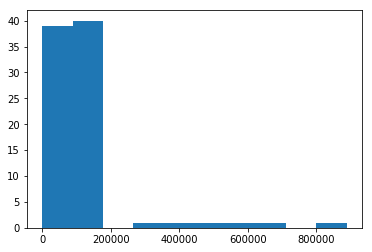

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
dataset=[]
for ind, row_azdias in feat_info.iterrows():
    col_azdias = row_azdias.attribute
    dataset.append(len(azdias[col_azdias]) - azdias[col_azdias].count())
    
plt.hist(dataset)

In [11]:
# Investigate patterns in the amount of missing data in each column.
miss_col = (azdias.isnull().sum() / len(azdias) * 100)


(array([ 32.,   7.,  37.,   3.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  0.        ,   4.98788179,   9.97576359,  14.96364538,
         19.95152717,  24.93940897,  29.92729076,  34.91517256,
         39.90305435,  44.89093614,  49.87881794,  54.86669973,
         59.85458152,  64.84246332,  69.83034511,  74.8182269 ,
         79.8061087 ,  84.79399049,  89.78187229,  94.76975408,  99.75763587]),
 <a list of 20 Patch objects>)

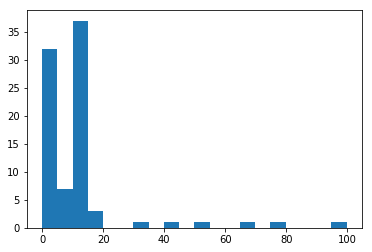

In [12]:
plt.hist(miss_col, bins=20)

In [13]:
miss_col = miss_col[miss_col>20].sort_values(ascending=False)


In [14]:
azdias.shape

(891221, 85)

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_ = miss_col[miss_col>20].index.tolist()
azdias = azdias.drop(drop_, axis=1)


In [16]:
azdias.shape

(891221, 79)

In [17]:
drop_

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

#### Discussion 1.1.2: Assess Missing Data in Each Column
We note that most of the data lost less than 20 percent of the data so we removed those that are above, these are :
['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

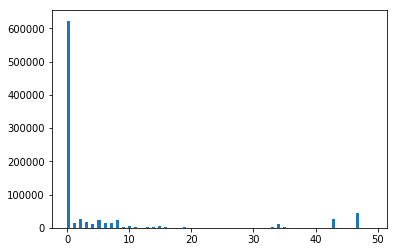

In [18]:
# How much data is missing in each row of the dataset?
miss_row =azdias.isnull().sum(axis=1)
plt.hist(miss_row, bins=100)
plt.show()


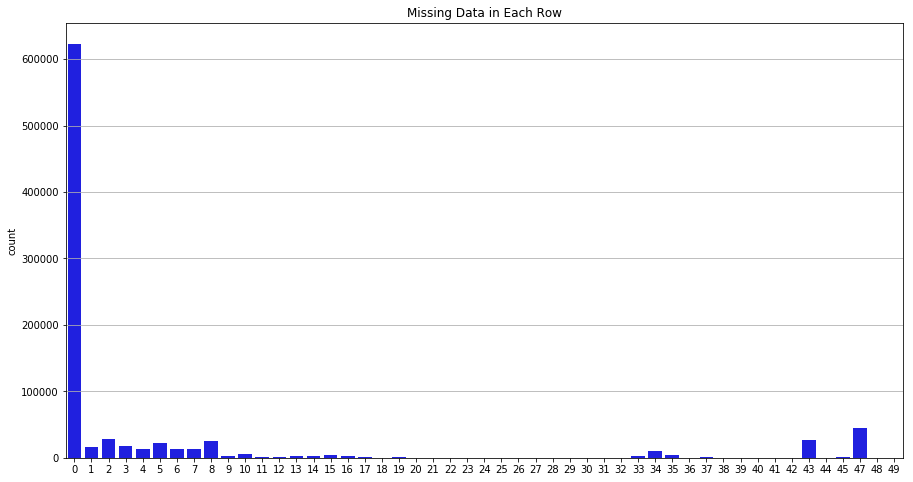

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
my_plot = azdias.isnull().sum(axis = 1).values
plt.figure(figsize=(15,8))
plt.grid(b=True)
plt.title("Missing Data in Each Row")
sns.countplot(my_plot, color='blue')

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [21]:
subset_1 = azdias[azdias.isnull().sum(axis=1) < 20].reset_index(drop=True)
subset_2 = azdias[azdias.isnull().sum(axis=1) >= 20].reset_index(drop=True)
subset_1plot = subset_1[subset_1.columns[:6]]
subset_2plot = subset_2[subset_2.columns[:6]]
first = (1-subset_1plot.shape[0]/azdias.shape[0])*100
second = (1-subset_2plot.shape[0]/azdias.shape[0])*100

print("The first subset has {:.2f} % missing values".format(first))
print("The second subset has {:.2f} % missing values".format(second))

The first subset has 10.56 % missing values
The second subset has 89.44 % missing values


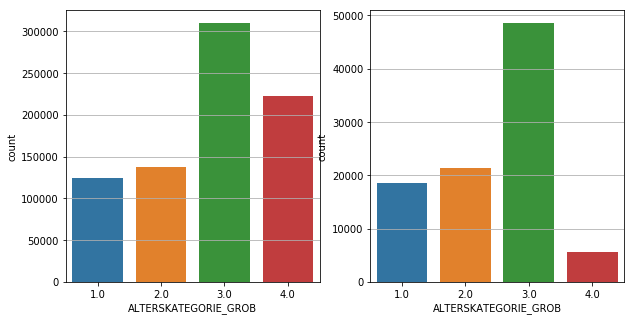

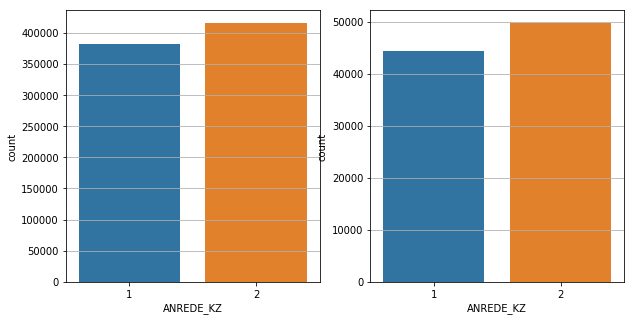

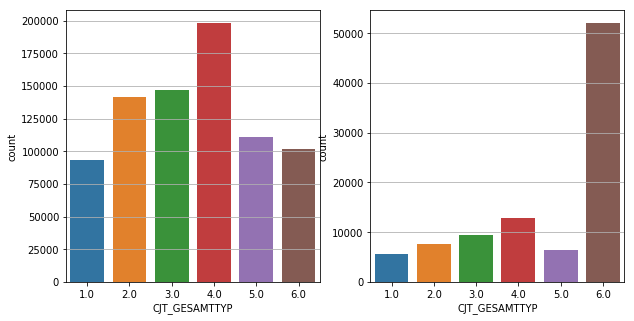

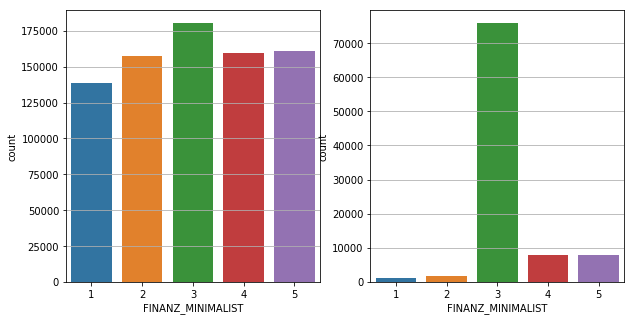

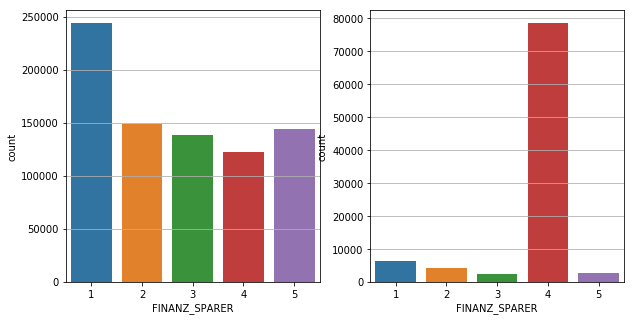

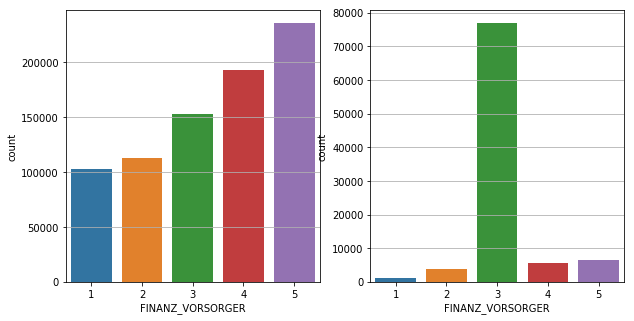

In [22]:
for x in subset_1plot:  
    plt.figure(figsize=(10,5))

    plt.subplot(121)
    plot_1 = subset_1plot[x]
    plt.grid(b=True)
    sns.countplot(plot_1)
    
    plt.subplot(122)
    plot_2 = subset_2plot[x]
    plt.grid(b=True)
    sns.countplot(plot_2)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The subset 1 only lost 10.5% of the values while the subset 2 lost 89.4% of the values. They are qualittatively differents.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info["type"].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [24]:
new_feat = feat_info.set_index("attribute")
new_feat = new_feat.drop(drop_, axis=0) 
new_feat["type"].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categ =[]
multi=[]
new_feat.reset_index(inplace=True)
for column in range(len(new_feat)):
    if new_feat.type[column] == 'categorical':
        if new_feat.attribute[column] in subset_1:
            features = len(subset_1[new_feat.attribute[column]].unique())
            multi.append(new_feat.attribute[column])
            if features <= 2:
                categ.append(new_feat.attribute[column])
categ           


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [26]:
features

45

In [27]:
print(multi)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
for feature in categ:
    print('Values for {} {}'.format(feature, subset_1[feature].unique()))

Values for ANREDE_KZ [2 1]
Values for GREEN_AVANTGARDE [0 1]
Values for SOHO_KZ [ 1.  0.]
Values for OST_WEST_KZ ['W' 'O']


In [29]:
new_v = {'W': 0, 'O':1}
subset_1 = subset_1.replace({'OST_WEST_KZ':new_v})

In [30]:
for feature in multi:
    subset_1 = subset_1.drop(feature, axis=1)

In [31]:
subset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797077 entries, 0 to 797076
Data columns (total 61 columns):
ALTERSKATEGORIE_GROB     794304 non-null float64
FINANZ_MINIMALIST        797077 non-null int64
FINANZ_SPARER            797077 non-null int64
FINANZ_VORSORGER         797077 non-null int64
FINANZ_ANLEGER           797077 non-null int64
FINANZ_UNAUFFAELLIGER    797077 non-null int64
FINANZ_HAUSBAUER         797077 non-null int64
HEALTH_TYP               760739 non-null float64
LP_LEBENSPHASE_FEIN      747590 non-null float64
LP_LEBENSPHASE_GROB      750398 non-null float64
PRAEGENDE_JUGENDJAHRE    768753 non-null float64
RETOURTYP_BK_S           792445 non-null float64
SEMIO_SOZ                797077 non-null int64
SEMIO_FAM                797077 non-null int64
SEMIO_REL                797077 non-null int64
SEMIO_MAT                797077 non-null int64
SEMIO_VERT               797077 non-null int64
SEMIO_LUST               797077 non-null int64
SEMIO_ERL                797077

#### Discussion 1.2.1: Re-Encode Categorical Features
keep all binary features and re-encoded the values of 'OST_WEST_KZ'. The multi features has been dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
subset_1['DECADE'] = subset_1['PRAEGENDE_JUGENDJAHRE']
subset_1['MOVEMENT'] = subset_1['PRAEGENDE_JUGENDJAHRE']

In [33]:
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4,
               10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0,
                 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}


In [35]:
subset_1['DECADE'].replace(decade, inplace=True)
subset_1['MOVEMENT'].replace(movement, inplace=True)

In [36]:
subset_1['WEALTH'] = subset_1['CAMEO_INTL_2015']
subset_1['LIFE_STAGE'] = subset_1['CAMEO_INTL_2015']

In [37]:
wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, 
               '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3,
               '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5,
                   '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, 
                   '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [38]:
subset_1['WEALTH'].replace(wealth, inplace=True)
subset_1['LIFE_STAGE'].replace(life_stage, inplace=True)

In [39]:
subset_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797077 entries, 0 to 797076
Data columns (total 65 columns):
ALTERSKATEGORIE_GROB     794304 non-null float64
FINANZ_MINIMALIST        797077 non-null int64
FINANZ_SPARER            797077 non-null int64
FINANZ_VORSORGER         797077 non-null int64
FINANZ_ANLEGER           797077 non-null int64
FINANZ_UNAUFFAELLIGER    797077 non-null int64
FINANZ_HAUSBAUER         797077 non-null int64
HEALTH_TYP               760739 non-null float64
LP_LEBENSPHASE_FEIN      747590 non-null float64
LP_LEBENSPHASE_GROB      750398 non-null float64
PRAEGENDE_JUGENDJAHRE    768753 non-null float64
RETOURTYP_BK_S           792445 non-null float64
SEMIO_SOZ                797077 non-null int64
SEMIO_FAM                797077 non-null int64
SEMIO_REL                797077 non-null int64
SEMIO_MAT                797077 non-null int64
SEMIO_VERT               797077 non-null int64
SEMIO_LUST               797077 non-null int64
SEMIO_ERL                797077

#### Discussion 1.2.2: Engineer Mixed-Type Features

I decided to keep 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' that now are a mixed value features.

I created two columns and these contains initial values from the features column then i created other variables to save initial values in order to replace the new features columns.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_features = new_feat[new_feat["type"]=="mixed"]["attribute"]
for feature in mixed_features:
    subset_1.drop(feature, axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [41]:
subset_1.shape

(797077, 59)

In [42]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    azdias.replace(to_replace='X', value=np.NaN, inplace=True)
    azdias.replace(to_replace='XX', value=np.NaN, inplace=True)
    
    for row_azdias in feat_info.itertuples():
        try:
            missv = eval(row_azdias.missing_or_unknown)
        except NameError: 
            missv = row_azdias.missing_or_unknown[1:-1].split(',')
            if 'X' in missv:
                missv.remove('X')
            if 'XX' in missv:
                missv.remove('XX')
        for no_item in missv:
            azdias[row_azdias.attribute] = azdias[row_azdias.attribute].where(azdias[row_azdias.attribute]!=no_item, other=np.NaN)
    
    # remove selected columns and rows, ...
    miss_col = (azdias.isnull().sum() / len(azdias) * 100)
    miss_col = miss_col[miss_col>20].sort_values(ascending=False)
    drop_ = miss_col[miss_col>20].index.tolist()
    azdias = azdias.drop(drop_, axis=1)
    
    subset_1 = azdias[azdias.isnull().sum(axis=1) < 20].reset_index(drop=True)
    new_feat = feat_info.set_index("attribute")
    new_feat = new_feat.drop(drop_, axis=0) 
    
    # select, re-encode, and engineer column values.
    
    categ =[]
    multi=[]
    new_feat.reset_index(inplace=True)
    for column in range(len(new_feat)):
        if new_feat.type[column] == 'categorical':
            if new_feat.attribute[column] in subset_1:
                features = len(subset_1[new_feat.attribute[column]].unique())
                multi.append(new_feat.attribute[column])
                if features <= 2:
                    categ.append(new_feat.attribute[column])
                    
    new_v = {'W': 0, 'O':1}
    subset_1 = subset_1.replace({'OST_WEST_KZ':new_v})
    
    for feature in multi:
        subset_1 = subset_1.drop(feature, axis=1)
    
    if "PRAEGENDE_JUGENDJAHRE" in subset_1.columns:
        subset_1['DECADE'] = subset_1['PRAEGENDE_JUGENDJAHRE']
        subset_1['MOVEMENT'] = subset_1['PRAEGENDE_JUGENDJAHRE']

        decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4,
                       10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

        movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0,
                         10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

        subset_1['DECADE'].replace(decade, inplace=True)
        subset_1['MOVEMENT'].replace(movement, inplace=True)
        
    if "CAMEO_INTL_2015" in subset_1.columns:
        
        subset_1['WEALTH'] = subset_1['CAMEO_INTL_2015']
        subset_1['LIFE_STAGE'] = subset_1['CAMEO_INTL_2015']

        wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, 
                       '21':2, '22':2, '23':2, '24':2, '25':2,
                       '31':3, '32':3, '33':3, '34':3, '35':3,
                       '41':4, '42':4, '43':4, '44':4, '45':4,
                       '51':5, '52':5, '53':5, '54':5, '55':5}

        life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5,
                           '21':1, '22':2, '23':3, '24':4, '25':5,
                           '31':1, '32':2, '33':3, '34':4, '35':5, 
                           '41':1, '42':2, '43':3, '44':4, '45':5,
                           '51':1, '52':2, '53':3, '54':4, '55':5}

        subset_1['WEALTH'].replace(wealth, inplace=True)
        subset_1['LIFE_STAGE'].replace(life_stage, inplace=True)
    
    mixed_features = new_feat[new_feat["type"]=="mixed"]["attribute"]
    for feature in mixed_features:
        subset_1.drop(feature, axis=1, inplace=True)
        
    # Return the cleaned dataframe.
    return subset_1

    
    
    
    
    

In [43]:
azdias_copy = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
subset_1 = clean_data(azdias_copy)

In [44]:
subset_1.shape

(797077, 59)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
for colmn in subset_1.columns:
    subset_1[colmn] = subset_1[colmn].fillna(subset_1[colmn].mode()[0])

In [46]:
# Apply feature scaling to the general population demographics data.
std = StandardScaler()
subset_1[subset_1.columns] = std.fit_transform(subset_1[subset_1.columns])


In [47]:
subset_1.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766173,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,1.010291,-1.684892,0.442419,...,0.441346,1.454540,0.573590,-0.171711,-0.127228,0.684698,1.098802,0.530654,1.175857,-1.249369
1,0.200733,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.010291,-0.310441,-0.072758,...,-0.935871,0.418829,0.573590,-0.171711,-0.127228,-0.789243,1.098802,-1.884467,-0.869590,0.766691
2,1.184186,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.311793,-0.997667,0.442419,...,-0.935871,-0.616882,0.573590,-1.173497,-0.997766,-0.052273,-0.267171,0.530654,-1.551406,-0.577349
3,0.200733,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,1.010291,1.064009,0.957596,...,0.441346,-0.616882,-0.337417,0.830075,0.308041,1.421668,-0.267171,0.530654,0.494041,0.094671
4,-1.766173,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,1.010291,-0.310441,-1.103113,...,0.441346,1.454540,1.484596,-1.173497,-0.997766,-0.052273,-1.633144,0.530654,1.175857,0.766691


### Discussion 2.1: Apply Feature Scaling
I replaced all missing values with the most frequent value in that column. Imputer and StandardScale were used as a function to scale.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.
pca = PCA()
pca.fit(subset_1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

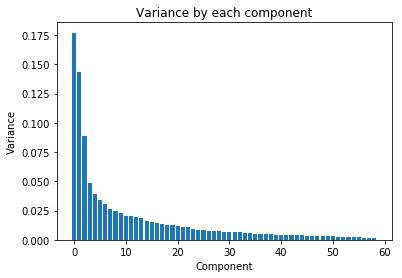

In [49]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title('Variance by each component')
plt.xlabel('Component')
plt.ylabel('Variance')
plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

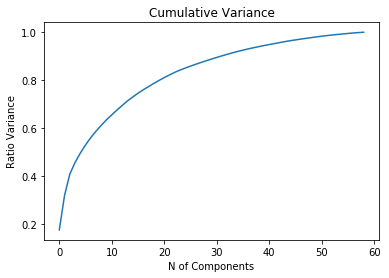

In [50]:
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), '-')
plt.title('Cumulative Variance')
plt.xlabel('N of Components')
plt.ylabel('Ratio Variance')
plt.show

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca28 = PCA(n_components=28)
pca_data = pca28.fit_transform(subset_1)


### Discussion 2.2: Perform Dimensionality Reduction

I decided to take 28 componentes, since graphically it gives the sensation of the minimum advance after the 30 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_map(pca,index):
    data = pd.DataFrame(pca.components_, columns=list(subset_1.columns))
    weights = data.iloc[index].sort_values(ascending=False)
    return weights

In [53]:
pc_w = pca_map(pca28,0)
pc_w

PLZ8_ANTG3               0.226998
PLZ8_ANTG4               0.218079
WEALTH                   0.203033
ORTSGR_KLS9              0.201056
EWDICHTE                 0.199325
HH_EINKOMMEN_SCORE       0.197767
FINANZ_SPARER            0.157931
PLZ8_ANTG2               0.156287
FINANZ_HAUSBAUER         0.155880
KBA05_ANTG4              0.153350
ARBEIT                   0.142066
RELAT_AB                 0.136931
KBA05_ANTG3              0.135891
ANZ_HAUSHALTE_AKTIV      0.135494
SEMIO_PFLICHT            0.126173
SEMIO_REL                0.124634
DECADE                   0.117333
SEMIO_RAT                0.102969
SEMIO_TRADV              0.099203
MOVEMENT                 0.098772
FINANZ_UNAUFFAELLIGER    0.087817
SEMIO_MAT                0.087231
SEMIO_FAM                0.086452
SEMIO_KULT               0.081314
FINANZ_ANLEGER           0.075550
REGIOTYP                 0.057426
SEMIO_SOZ                0.047461
PLZ8_HHZ                 0.044541
HEALTH_TYP               0.041204
SEMIO_KAEM    

In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_w = pca_map(pca28,1)
pc_w

ALTERSKATEGORIE_GROB     0.259400
FINANZ_VORSORGER         0.233550
SEMIO_ERL                0.217140
SEMIO_LUST               0.182697
RETOURTYP_BK_S           0.168631
FINANZ_HAUSBAUER         0.121896
W_KEIT_KIND_HH           0.120835
PLZ8_ANTG3               0.107074
EWDICHTE                 0.106813
ORTSGR_KLS9              0.105307
PLZ8_ANTG4               0.104421
SEMIO_KRIT               0.100545
SEMIO_KAEM               0.095894
WEALTH                   0.085611
KBA05_ANTG4              0.080552
ARBEIT                   0.076578
RELAT_AB                 0.075199
PLZ8_ANTG2               0.074889
ANZ_HAUSHALTE_AKTIV      0.071227
HH_EINKOMMEN_SCORE       0.064868
FINANZ_MINIMALIST        0.064376
WOHNDAUER_2008           0.059005
SEMIO_DOM                0.055358
KBA05_ANTG3              0.054481
ANZ_HH_TITEL             0.033811
PLZ8_HHZ                 0.018055
MOVEMENT                 0.015898
REGIOTYP                 0.012619
ANZ_TITEL                0.007497
KKK           

In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_w = pca_map(pca28,2)
pc_w


SEMIO_VERT               0.375152
SEMIO_SOZ                0.293105
SEMIO_FAM                0.285019
SEMIO_KULT               0.270223
FINANZ_MINIMALIST        0.163513
RETOURTYP_BK_S           0.102825
SEMIO_REL                0.099066
FINANZ_VORSORGER         0.092821
W_KEIT_KIND_HH           0.083066
SEMIO_MAT                0.077842
ALTERSKATEGORIE_GROB     0.058380
SEMIO_LUST               0.053601
PLZ8_ANTG4               0.039608
ORTSGR_KLS9              0.038836
EWDICHTE                 0.038311
PLZ8_ANTG3               0.038258
WOHNDAUER_2008           0.032404
ARBEIT                   0.029175
RELAT_AB                 0.026878
PLZ8_ANTG2               0.025763
KBA05_ANTG4              0.022833
WEALTH                   0.021737
ANZ_HAUSHALTE_AKTIV      0.020551
ANZ_HH_TITEL             0.011817
ANZ_TITEL                0.009747
KBA05_ANTG3              0.005000
PLZ8_HHZ                 0.002747
ANZ_PERSONEN            -0.003825
KBA05_ANTG2             -0.008130
LIFE_STAGE    

### Discussion 2.3: Interpret Principal Components

These data are an interpretation of the personal and social status of the consumer, for example:
ALTERSKATEGORIE_GROB     0.259400 in the first principal component,
is a interpretation of estimated age based on given name analysis
when this value is negative in ALTERSKATEGORIE_GROB case the estimation is unkonwn and missing, and when these characteristics are correlated the interpretation of your data is combined.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [56]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score    
    

In [57]:
scores = []
ks = list(range(1,20))
for k in ks:
    scores.append(k_mean_score(pca_data, k))


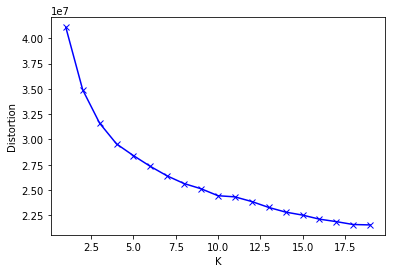

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(ks, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

In [59]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans =KMeans(n_clusters=10)
model = kmeans.fit(pca_data)
pred = model.predict(pca_data)


### Discussion 3.1: Apply Clustering to General Population


According to the graph we take 10 as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [61]:
customers_clean = clean_data(customer)

In [62]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,...,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,ONLINE_AFFINITAET
0,4.0,5,1,5,1,2,2,5.0,6,5,...,3,4,1,3,1,1,2,1,1.0,3.0
1,4.0,5,1,5,1,3,2,NaN,3,6,...,3,4,1,3,3,2,4,1,NaN,NaN
2,4.0,5,1,5,1,4,4,5.0,2,2,...,7,1,2,7,5,6,4,1,1.0,1.0
3,4.0,5,1,5,2,1,2,3.0,6,5,...,3,4,3,3,3,3,3,4,4.0,2.0
4,3.0,3,1,4,4,5,2,5.0,4,5,...,4,5,5,3,5,2,5,4,6.0,5.0


In [63]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d
customers_clean= fix_columns(customers_clean, subset_1.columns.tolist())


{'WEALTH', 'ARBEIT', 'RELAT_AB', 'INNENSTADT', 'PLZ8_ANTG4', 'KBA05_ANTG4', 'PLZ8_ANTG3', 'ANZ_TITEL', 'KBA05_ANTG2', 'KKK', 'MOBI_REGIO', 'HEALTH_TYP', 'KBA05_GBZ', 'PLZ8_ANTG1', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW', 'KBA05_ANTG3', 'PLZ8_HHZ', 'KBA05_ANTG1', 'MIN_GEBAEUDEJAHR', 'PLZ8_ANTG2', 'WOHNDAUER_2008', 'KONSUMNAEHE', 'REGIOTYP', 'GEBAEUDETYP_RASTER', 'BALLRAUM', 'MOVEMENT', 'EWDICHTE', 'W_KEIT_KIND_HH', 'PLZ8_GBZ', 'ORTSGR_KLS9', 'ANZ_PERSONEN', 'DECADE', 'LIFE_STAGE', 'ANZ_HAUSHALTE_AKTIV'}


In [64]:
for colmn in customers_clean.columns:
    customers_clean[colmn] = customers_clean[colmn].fillna(customers_clean[colmn].mode()[0])

In [65]:
customers_clean[customers_clean.columns] = std.fit_transform(customers_clean[customers_clean.columns])

In [66]:
cust_only = customers_clean.copy()

In [67]:
pca.fit(customers_clean)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [68]:
customers_clean = pca28.transform(customers_clean)

In [69]:
customers_clean

array([[-1.5913742 ,  1.32899878,  3.92796657, ..., -0.21742852,
        -0.12937359,  0.27430627],
       [-1.05514767,  0.65007802,  2.73602872, ...,  0.12722524,
         0.37546514,  0.54445245],
       [-1.52431061,  3.48806538, -1.72613234, ...,  0.03474511,
         0.02239678,  0.1477788 ],
       ..., 
       [-1.67492893,  2.69848299,  1.44487793, ...,  0.2439005 ,
         0.06480189, -0.33302052],
       [ 0.43073505,  2.2967173 , -2.42443963, ...,  0.2608096 ,
         0.51746921,  0.34206609],
       [ 1.19555787, -2.40508425,  2.60787766, ...,  0.63648162,
         0.63665371, -0.46219137]])

In [70]:
customers_model = kmeans.fit(customers_clean)
customers_pred = customers_model.predict(customers_clean)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'general population')

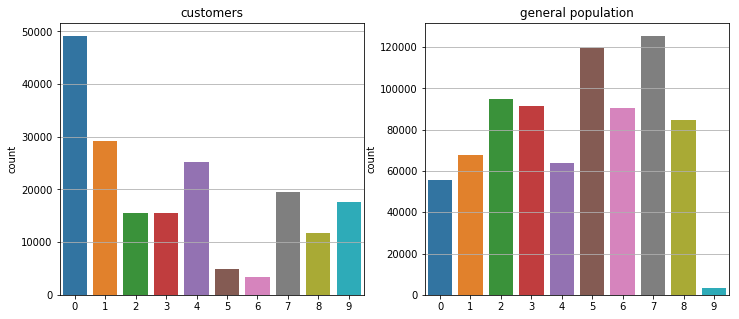

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plt.figure(figsize=(12,5))
#figure.subplots_adjust(hspace = 2, wspace=.3)

plt.subplot(121)
plt.grid(b=True)
sns.countplot(customers_pred)
plt.title("customers")

plt.subplot(122)
plt.grid(b=True)
sns.countplot(pred)
plt.title("general population")

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
col = std.inverse_transform(pca28.inverse_transform(customers_model.cluster_centers_[5]))

In [73]:
overr = pd.Series(data = col, index = cust_only.columns)
overr

ALTERSKATEGORIE_GROB     1.428580
FINANZ_MINIMALIST        4.151535
FINANZ_SPARER            2.577049
FINANZ_VORSORGER         3.710406
FINANZ_ANLEGER           2.465618
FINANZ_UNAUFFAELLIGER    3.058765
FINANZ_HAUSBAUER         2.238810
HEALTH_TYP              -0.121961
RETOURTYP_BK_S           3.351773
SEMIO_SOZ                6.985778
SEMIO_FAM                7.004805
SEMIO_REL                7.313802
SEMIO_MAT                5.550591
SEMIO_VERT               6.782558
SEMIO_LUST               3.181181
SEMIO_ERL                1.327119
SEMIO_KULT               6.513532
SEMIO_RAT                4.075080
SEMIO_KRIT               2.815004
SEMIO_DOM                3.110017
SEMIO_KAEM               2.141318
SEMIO_PFLICHT            5.430262
SEMIO_TRADV              4.659299
ANZ_PERSONEN            -0.033566
ANZ_TITEL               -0.006840
HH_EINKOMMEN_SCORE       2.903549
W_KEIT_KIND_HH          -0.266173
WOHNDAUER_2008          -0.122068
ANZ_HAUSHALTE_AKTIV     -0.001849
ANZ_HH_TITEL  

In [74]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
col2= std.inverse_transform(pca28.inverse_transform(customers_model.cluster_centers_[1]))
underr = pd.Series(data = col2, index = cust_only.columns)
underr

ALTERSKATEGORIE_GROB     3.432852
FINANZ_MINIMALIST        4.879678
FINANZ_SPARER            1.383261
FINANZ_VORSORGER         4.595065
FINANZ_ANLEGER           1.384048
FINANZ_UNAUFFAELLIGER    1.851407
FINANZ_HAUSBAUER         1.938767
HEALTH_TYP              -0.092267
RETOURTYP_BK_S           3.893870
SEMIO_SOZ                4.661896
SEMIO_FAM                4.634694
SEMIO_REL                3.634978
SEMIO_MAT                1.869119
SEMIO_VERT               5.904801
SEMIO_LUST               5.457856
SEMIO_ERL                3.884668
SEMIO_KULT               4.173792
SEMIO_RAT                1.835004
SEMIO_KRIT               3.481914
SEMIO_DOM                3.300610
SEMIO_KAEM               2.754038
SEMIO_PFLICHT            2.940681
SEMIO_TRADV              2.077753
ANZ_PERSONEN            -0.013926
ANZ_TITEL               -0.035607
HH_EINKOMMEN_SCORE       2.645004
W_KEIT_KIND_HH          -0.118364
WOHNDAUER_2008          -0.006559
ANZ_HAUSHALTE_AKTIV     -0.143059
ANZ_HH_TITEL  

### Discussion 3.3: Compare Customer Data to Demographics Data

The components 1 and 6 are overrepresented and cluster 5 shows characteristics of a couple between 30 and 45 years with average-high economy.

The components 3 and 9 are underrepresented and cluster 1 shows characteristics of a couple between 46 and 60 years with very low economy with personality typology average.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.